Point Target Detection for Video
Processing video file: /Users/Vaibhav/Videos/Screen_Recording_2025-04-08_110859.mp4
Video properties: 1870x764, 30 FPS, 796 frames


C:\Users\Vaibhav\AppData\Local\Temp\ipykernel_1528\3345088625.py:52: RuntimeWarning: overflow encountered in scalar subtract
  r = (s0 - s1) / (s1 - s2 + 1e-6)


Processed frame 30/796 - Targets detected: 15
Processed frame 60/796 - Targets detected: 20
Processed frame 90/796 - Targets detected: 17
Processed frame 120/796 - Targets detected: 24
Processed frame 150/796 - Targets detected: 20
Processed frame 180/796 - Targets detected: 19
Processed frame 210/796 - Targets detected: 18
Processed frame 240/796 - Targets detected: 16
Processed frame 270/796 - Targets detected: 14
Processed frame 300/796 - Targets detected: 14
Processed frame 330/796 - Targets detected: 13
Processed frame 360/796 - Targets detected: 10
Processed frame 390/796 - Targets detected: 10
Processed frame 420/796 - Targets detected: 7
Processed frame 450/796 - Targets detected: 6
Processed frame 480/796 - Targets detected: 7
Processed frame 510/796 - Targets detected: 8
Processed frame 540/796 - Targets detected: 6
Processed frame 570/796 - Targets detected: 8
Processed frame 600/796 - Targets detected: 6
Processed frame 630/796 - Targets detected: 9
Processed frame 660/796 

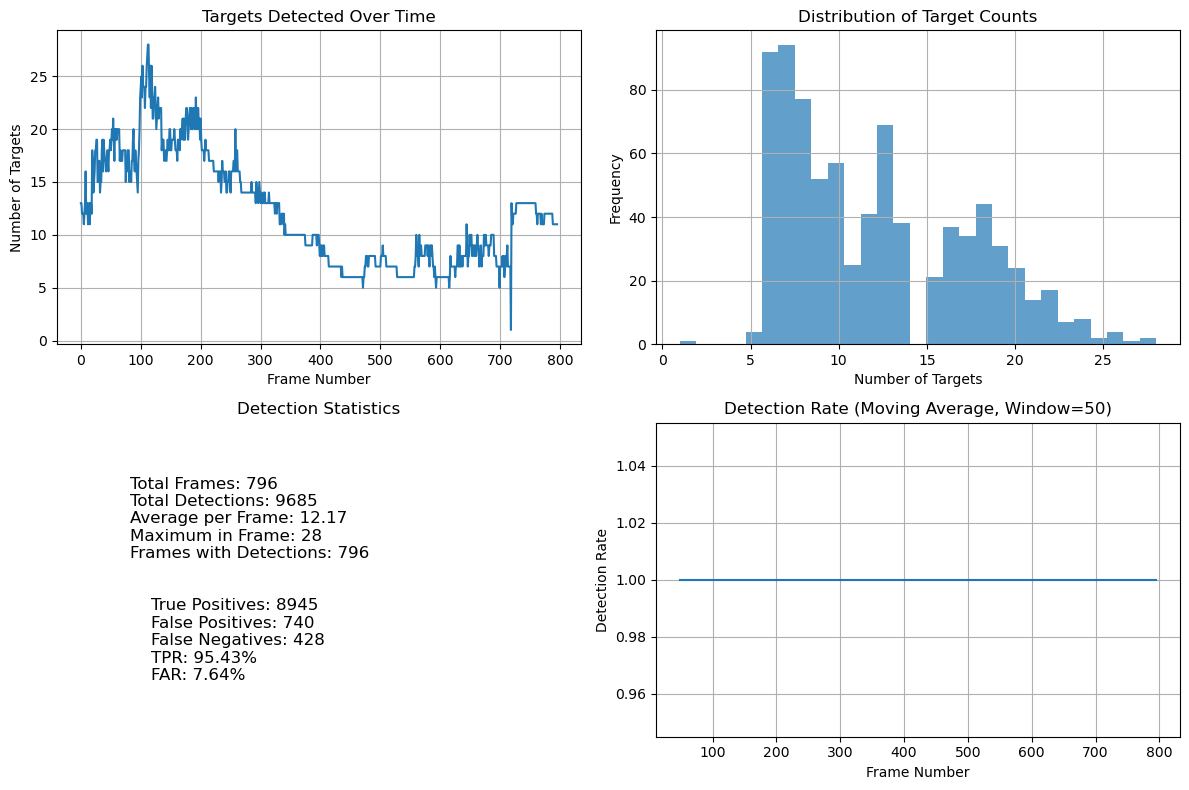

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import time

class PointTargetDetector:
    def __init__(self):
        self.frame_count = 0
        self.detection_history = []

    def point_spread_local_contrast_fast(self, img):
        I0 = img
        direct = np.stack([
            np.roll(img, 1, axis=0),
            np.roll(img, -1, axis=0),
            np.roll(img, 1, axis=1),
            np.roll(img, -1, axis=1)
        ])
        neighbors = np.stack([
            np.roll(img, (1, 1), axis=(0, 1)),
            np.roll(img, (1, -1), axis=(0, 1)),
            np.roll(img, (-1, 1), axis=(0, 1)),
            np.roll(img, (-1, -1), axis=(0, 1)),
            *direct
        ])
        L = np.min(I0 ** 2 / (neighbors + 1e-6), axis=0)
        r = np.min(direct, axis=0) / (np.max(direct, axis=0) + 1e-6)
        return r * L

    def high_boost_enhancement(self, PSLCM):
        MF = cv2.GaussianBlur(PSLCM, (9, 9), 1)
        B = np.maximum(PSLCM - MF, 1)
        enhanced = PSLCM * B
        return enhanced

    def normalize_image(self, enhanced_img):
        norm = cv2.normalize(enhanced_img, None, 0, 255, cv2.NORM_MINMAX)
        return norm.astype(np.uint8)

    def adaptive_segmentation(self, enhanced):
        V = np.sort(enhanced.flatten())[::-1]
        S = np.unique(V)
        len_S = len(S)

        if len_S < 3:
            T = V[0] if len(V) > 0 else 0
            return (enhanced >= T).astype(np.uint8) * 255

        for i in range(min(10, len_S - 3), 1, -1):
            s0, s1, s2 = S[i], S[i + 1], S[i + 2]
            r = (s0 - s1) / (s1 - s2 + 1e-6)
            if r > 0.1:
                T = s0
                break
            elif r < 0.0:
                T = s1
                break
        else:
            T = V[10] if len(V) > 10 else V[-1]

        mask = (enhanced >= T).astype(np.uint8) * 255
        return mask

    def mark_targets_on_original(self, original_img, binary_mask):
        if original_img.dtype != np.uint8:
            original_display = cv2.normalize(original_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        else:
            original_display = original_img.copy()

        marked_img = cv2.cvtColor(original_display, cv2.COLOR_GRAY2BGR)
        target_centers = []
        target_count = 0

        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            area = cv2.contourArea(contour)
            if area < 1:
                continue

            target_count += 1
            x, y, w, h = cv2.boundingRect(contour)
            center_x = x + w // 2
            center_y = y + h // 2
            target_centers.append((center_x, center_y))
            cv2.rectangle(marked_img, (x, y), (x + w, y + h), (0, 0, 255), 2)
            cv2.circle(marked_img, (center_x, center_y), 3, (0, 255, 0), -1)

        return marked_img, target_centers, target_count

    def process_frame(self, frame):
        if len(frame.shape) == 3:
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        else:
            gray_frame = frame.copy()

        img = gray_frame.astype(np.float32)
        PSLCM = self.point_spread_local_contrast_fast(img)
        enhanced_img = self.high_boost_enhancement(PSLCM)
        enhanced_image = self.normalize_image(enhanced_img)
        binary_mask = self.adaptive_segmentation(enhanced_image)

        marked_frame, target_centers, target_count = self.mark_targets_on_original(gray_frame, binary_mask)

        detection_info = {
            'frame_number': self.frame_count,
            'target_count': target_count,
            'target_centers': target_centers,
            'timestamp': time.time()
        }

        self.detection_history.append(detection_info)
        self.frame_count += 1

        return marked_frame, binary_mask, detection_info

def process_video_file(video_path, output_path=None, display_results=True, save_frames=False):
    """
    Process a video file for point target detection
    """
    detector = PointTargetDetector()
    
    # Open video file
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error: Cannot open video file {video_path}")
        return None
    
    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"Video properties: {width}x{height}, {fps} FPS, {total_frames} frames")
    
    # Initialize video writer if output path is provided
    if output_path:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    frame_results = []
    
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            # Process frame
            marked_frame, binary_mask, detection_info = detector.process_frame(frame)
            frame_results.append(detection_info)
            
            # Display progress
            if detector.frame_count % 30 == 0:  # Every 30 frames
                print(f"Processed frame {detector.frame_count}/{total_frames} - "
                      f"Targets detected: {detection_info['target_count']}")
            
            # Save processed frame
            if output_path:
                out.write(marked_frame)
            
            # Display results in Jupyter Notebook (every 10th frame to avoid flooding)
            if display_results and detector.frame_count % 10 == 0:
                plt.figure(figsize=(15, 5))
                
                plt.subplot(1, 3, 1)
                plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                plt.title(f'Original Frame {detector.frame_count}')
                plt.axis('off')
                
                plt.subplot(1, 3, 2)
                plt.imshow(cv2.cvtColor(marked_frame, cv2.COLOR_BGR2RGB))
                plt.title(f'Detected Targets: {detection_info["target_count"]}')
                plt.axis('off')
                
                plt.subplot(1, 3, 3)
                plt.imshow(binary_mask, cmap='gray')
                plt.title('Binary Mask')
                plt.axis('off')
                
                plt.tight_layout()
                plt.show()
                
                # Print detection summary
                if detection_info['target_centers']:
                    print(f"Frame {detector.frame_count}: {detection_info['target_count']} targets at {detection_info['target_centers']}")
            
            # Save individual frames if requested
            if save_frames and detector.frame_count % 30 == 0:
                cv2.imwrite(f'frame_{detector.frame_count:04d}_marked.jpg', marked_frame)
                cv2.imwrite(f'frame_{detector.frame_count:04d}_mask.jpg', binary_mask)
    
    except KeyboardInterrupt:
        print("Processing interrupted by user")
    
    finally:
        cap.release()
        if output_path:
            out.release()
    
    print(f"\nProcessing complete! Processed {detector.frame_count} frames")
    print(f"Detection history saved with {len(detector.detection_history)} entries")
    
    return detector, frame_results

def process_webcam_live(duration=30, display_interval=1):
    """
    Process live webcam feed for point target detection
    """
    detector = PointTargetDetector()
    
    # Open webcam
    cap = cv2.VideoCapture(0)
    
    if not cap.isOpened():
        print("Error: Cannot open webcam")
        return None
    
    start_time = time.time()
    last_display = 0
    
    print(f"Starting live webcam processing for {duration} seconds...")
    print("Press 'q' to quit early")
    
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                print("Failed to grab frame")
                break
            
            # Check if duration exceeded
            current_time = time.time()
            if current_time - start_time > duration:
                break
            
            # Process frame
            marked_frame, binary_mask, detection_info = detector.process_frame(frame)
            
            # Display results at specified interval
            if current_time - last_display > display_interval:
                plt.figure(figsize=(15, 5))
                
                plt.subplot(1, 3, 1)
                plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                plt.title(f'Live Feed - Frame {detector.frame_count}')
                plt.axis('off')
                
                plt.subplot(1, 3, 2)
                plt.imshow(cv2.cvtColor(marked_frame, cv2.COLOR_BGR2RGB))
                plt.title(f'Targets: {detection_info["target_count"]}')
                plt.axis('off')
                
                plt.subplot(1, 3, 3)
                plt.imshow(binary_mask, cmap='gray')
                plt.title('Detection Mask')
                plt.axis('off')
                
                plt.tight_layout()
                plt.show()
                
                if detection_info['target_centers']:
                    print(f"Targets detected: {detection_info['target_centers']}")
                
                last_display = current_time
    
    except KeyboardInterrupt:
        print("Live processing interrupted by user")
    
    finally:
        cap.release()
    
    print(f"\nLive processing complete! Processed {detector.frame_count} frames")
    return detector

def analyze_detection_results(detector, ground_truth_csv=None):
    """
    Analyze and visualize detection results (extended with TPR & FAR)
    """
    if not detector.detection_history:
        print("No detection history available")
        return
    
    # Extract detection history
    frame_numbers = [d['frame_number'] for d in detector.detection_history]
    target_counts = [d['target_count'] for d in detector.detection_history]

    plt.figure(figsize=(12, 8))
    
    # Plot detections per frame
    plt.subplot(2, 2, 1)
    plt.plot(frame_numbers, target_counts)
    plt.title('Targets Detected Over Time')
    plt.xlabel('Frame Number')
    plt.ylabel('Number of Targets')
    plt.grid(True)

    # Histogram
    plt.subplot(2, 2, 2)
    plt.hist(target_counts, bins=max(target_counts)+1, alpha=0.7)
    plt.title('Distribution of Target Counts')
    plt.xlabel('Number of Targets')
    plt.ylabel('Frequency')
    plt.grid(True)

    # Stats + TPR/FAR if ground truth available
    plt.subplot(2, 2, 3)
    total_detections = sum(target_counts)
    avg_detections = np.mean(target_counts)
    max_detections = max(target_counts)

    stats_text = f"""
    Total Frames: {len(frame_numbers)}
    Total Detections: {total_detections}
    Average per Frame: {avg_detections:.2f}
    Maximum in Frame: {max_detections}
    Frames with Detections: {sum(1 for c in target_counts if c > 0)}
    """

    if ground_truth_csv:
        TP, FP, FN, TPR, FAR = compute_tpr_far(detector, ground_truth_csv)
        stats_text += f"""

        True Positives: {TP}
        False Positives: {FP}
        False Negatives: {FN}
        TPR: {TPR*100:.2f}%
        FAR: {FAR*100:.2f}%
        """

    plt.text(0.1, 0.5, stats_text, fontsize=12, verticalalignment='center')
    plt.title('Detection Statistics')
    plt.axis('off')

    # Detection rate
    plt.subplot(2, 2, 4)
    detection_rate = [1 if c > 0 else 0 for c in target_counts]
    window_size = min(50, len(detection_rate))
    if window_size > 1:
        smoothed_rate = np.convolve(detection_rate, np.ones(window_size)/window_size, mode='valid')
        plt.plot(range(window_size-1, len(detection_rate)), smoothed_rate)
        plt.title(f'Detection Rate (Moving Average, Window={window_size})')
        plt.xlabel('Frame Number')
        plt.ylabel('Detection Rate')
        plt.grid(True)

    plt.tight_layout()
    plt.show()

    
def main():
    print("Point Target Detection for Video")
    print("=" * 40)
    
    # Example usage - replace with your video file path
    video_file = "/Users/Vaibhav/Videos/Screen_Recording_2025-04-08_110859.mp4"  # Update this path
    
    # Check if video file exists
    if os.path.exists(video_file):
        print(f"Processing video file: {video_file}")
        detector, results = process_video_file(
            video_file, 
            output_path="/Users/Vaibhav/Videos/output video4.mp4",
            display_results=True,
            save_frames=False
        )
        
        if detector:
            analyze_detection_results(detector, ground_truth_csv="/Users/Vaibhav/Downloads/detections_output_modified.csv")
    else:
        print(f"Video file not found: {video_file}")
        print("Please update the video_file path or use webcam processing")
        
        # Alternative: Process webcam (uncomment to use)
        # print("Starting webcam processing...")
        # detector = process_webcam_live(duration=30, display_interval=2)
        # if detector:
        #     analyze_detection_results(detector)

if __name__ == "__main__":
    main()
